In [260]:
import os 
import xarray as xr
import numpy as np
import pandas as pd
from keras import models 
from keras import layers 
from keras.utils import plot_model
from sklearn.model_selection import train_test_split 
from keras import callbacks 
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import random
import pywt
from sklearn.decomposition import PCA
import time
import datetime
import re
import glob
import matplotlib.dates as dates
import talos 
from talos.model.normalizers import lr_normalizer
from talos.model.early_stopper import early_stopper
import tensorflow as tf
import sys
import copy


In [154]:
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=5, 
                        inter_op_parallelism_threads=5,allow_soft_placement=True)

session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [452]:
def target(X,buoy):
    '''
    X numerical model with multiindex names: 
        - fctime (seconds)
        - buoy
        - time 
    buoy Hs, U and Tp data with multiindex:
        - buoy 
        - time
    '''
    l=len(X.index)   
    
    errorh=np.empty((0))
    #errort=np.empty((0))
    erroru=np.empty((0))
    for i in range(l):    
        time=datetime.datetime.strptime(X.index.get_level_values('time')[i], '%Y-%m-%d %H:%M:%S') #+timedelta(seconds=fctime)
        ind=np.where(
            np.logical_and(buoy.index.get_level_values('time') >= (time - timedelta(minutes=40)).strftime('%Y-%m-%d %H:%M:%S'), 
            buoy.index.get_level_values('time') <= (time + timedelta(minutes=40)).strftime('%Y-%m-%d %H:%M:%S')))

        if len(ind[0])!=0: #if a position was found, append to array of errors abs of difference
            errorh = np.append(errorh, X['swh'].values[i] - np.mean(buoy['WVHT'].values[ind])) 
            #errort = np.append(errort, X['pp1d'].values[i] - np.mean(buoy['DPD'].values[ind]))#!!
            erroru = np.append(erroru, X['uwnd'].values[i] - np.mean(buoy['uWDIR'].values[ind])) 
        else: #if no position was found
            errorh = np.append(errorh, np.nan)
            #errort = np.append(errort, np.nan)
            erroru = np.append(erroru, np.nan)
    y = pd.DataFrame(list(zip(errorh,erroru)),
                    columns =['errorh','erroru'])#, 'errort'
    return y

def directionComp( X, directionVars, speedVars):
    '''
    Input: 
        - X - dataframe
        - directionVars - list of direction variables' names  
        - speedVars - list of corresponding speed variables' names, when inexistent = None 
    Output: X with u & v components 
    
    '''  
    if len(directionVars) != len(speedVars):
        error='Variable lists must have same length'
        return error
    for i in range(0,len(directionVars)):
        if any(var == directionVars[i] for var in X.columns): #confirm if that variable is in X
            X=X.dropna(subset=[directionVars[i]]) #remove nans from dataframe            
            if speedVars[i] != None:
                X=X.dropna(subset=[speedVars[i]]) #remove nans from dataframe
                d=X[directionVars[i]].values
                s=X[speedVars[i]].values
                u=-s*np.sin(np.pi*d/180)
                v=-s*np.cos(np.pi*d/180)        
                del X[directionVars[i]]
                del X[speedVars[i]]
                X['u%s'%(directionVars[i])]=u
                X['v%s'%(directionVars[i])]=v
            else:
                d=X[directionVars[i]].values
                u=np.sin(np.pi*d/180)
                v=np.cos(np.pi*d/180)        
                del X[directionVars[i]]
                X['u%s'%(directionVars[i])]=u
                X['v%s'%(directionVars[i])]=v
        else: 
            print('Direction variable %s is not in X'%(directionVars[i]))    
    return X

def generate_dataset(input_scaler, output_scaler,X,y):

    '''
    scaler can be MinMaxScaler(), StandardScaler() or None
    X - input data with time as index
    y - output data
    '''    
    # split into train and test
    test_size=int(0.2*len(X)) #split can't be shuffled because of wt
    X_train=X[test_size:]
    y_train=y[test_size:]
    X_test=X[:test_size]
    y_test=y[:test_size]

    # scale inputs
    if input_scaler is not None:
        input_scaler.fit(X_train)
        X_train = input_scaler.transform(X_train)
        X_test = input_scaler.transform(X_test)
        
    if output_scaler is not None:
        output_scaler.fit(y_train)
        y_train = output_scaler.transform(y_train)
        y_test = output_scaler.transform(y_test)
    return X_train, X_test, y_train, y_test, output_scaler

def metricsB(*args):
    '''
    Error Metrics. Mentaschi et al. (2013)
    Input: two arrays of model and observation, respectively.
        They must have the same size
    Output: ferr array with shape equal to 8
        bias, RMSE, NBias, NRMSE, SCrmse, SI, HH, CC
    '''
    vmin=-np.inf; vmax=np.inf; maxdiff=np.inf
    if len(args) < 2:
        sys.exit(' Need two arrays with model and observations.')
    elif len(args) == 2:
        model=copy.copy(args[0]); obs=copy.copy(args[1])
    elif len(args) == 3:
        model=copy.copy(args[0]); obs=copy.copy(args[1])
        vmin=copy.copy(args[2])
    elif len(args) == 4:
        model=copy.copy(args[0]); obs=copy.copy(args[1])
        vmin=copy.copy(args[2]); vmax=copy.copy(args[3])
    elif len(args) == 5:
        model=copy.copy(args[0]); obs=copy.copy(args[1])
        vmin=copy.copy(args[2]); vmax=copy.copy(args[3]); maxdiff=copy.copy(args[4]);
    elif len(args) > 5:
        sys.exit(' Too many inputs')

    model=np.atleast_1d(model); obs=np.atleast_1d(obs)
    if model.shape != obs.shape:
        sys.exit(' Model and Observations with different size.')
    if vmax<=vmin:
        sys.exit(' vmin cannot be higher than vmax.')

    ind=np.where((np.isnan(model)==False) & (np.isnan(obs)==False) & (model>vmin) & (model<vmax) & (obs>vmin) & (obs<vmax) & (np.abs(model-obs)<=maxdiff) )
    
    if np.any(ind) or model.shape[0]==1:
        model=np.copy(model[ind[0]]); obs=np.copy(obs[ind[0]])
    else:
        print(' Array without valid numbers.')
        return np.zeros((8),'f')*np.nan # TODO is this correct

    ferr=np.zeros((8),'f')*np.nan
    ferr[0] = model.mean()-obs.mean() # Bias
    ferr[1] = (((model-obs)**2).mean())**0.5 # RMSE
    if obs.mean()!=0.:
        ferr[2] = ferr[0] / np.abs(obs.mean()) # Normalized Bias 
    ferr[3] = ( ((model-obs)**2).sum() / (obs**2).sum() )**0.5  # Normalized RMSE
    # ferr[4] = ((((model-model.mean())-(obs-obs.mean()))**2).mean())**0.5   # Scatter Component of RMSE
    if ( (ferr[1]**2) - (ferr[0]**2) ) >= 0.:
        ferr[4] = ( (ferr[1]**2) - (ferr[0]**2) )**0.5
    ferr[5] = ( (((model-model.mean())-(obs-obs.mean()))**2).sum() / (obs**2).sum() )**0.5  # Scatter Index
    ferr[6] = ( ((model - obs)**2).sum() / (model * obs).sum() )**0.5  # HH
    ferr[7]=np.corrcoef(model,obs)[0,1]  #  Correlation Coefficient

    return ferr

In [3]:
buoysdata=pd.read_csv('buoysdata1516.txt', sep=" ", header=0,index_col=[0,1])
reanalysis=pd.read_csv('era5_1516.txt', sep=" ", header=0,index_col=[0,1,2])
reanalysis.rename(index={41004:41044}, level='buoy', inplace=True)
buoyslist=np.unique(buoysdata.index.get_level_values('buoy'))
print(buoyslist)
print(reanalysis.columns)

[41010 41040 41044 41048 42003]
Index(['swh1', 'mwd1', 'mwp1', 'swh2', 'mwd2', 'mwp2', 'swh3', 'mwd3', 'mwp3',
       'u850', 'v850', 'msl', 'uwnd', 'vwnd', 'atmp', 'dewp', 'tmax', 'hmax',
       'm0wp', 'wdw', 'dwww', 'dwps', 'swh', 'mwd', 'pp1d', 'mwp', 'shww',
       'mdww', 'mpww', 'shts', 'mdts', 'mpts', 'i10fg', 'sst', '10fg', 'hgt'],
      dtype='object')


In [4]:
k=2
B=directionComp(buoysdata.iloc[buoysdata.index.get_level_values('buoy')==buoyslist[k]],['WDIR'],['WSPD']).sort_values(by='time')
R=directionComp(reanalysis.iloc[reanalysis.index.get_level_values('buoy')==buoyslist[k]],
                ['mwd','mwd1','mwd2','mwd3','mdww','mdts'],[None,None,None,None,None,None]).sort_values(by='time')

In [233]:
tt=[datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S').timetuple().tm_yday for x in R.index.get_level_values('time')]
tt = np.array(tt, dtype=np.float32)
tc=np.cos(tt*np.pi*2/(np.max(tt)-np.min(tt)))
ts=np.sin(tt*np.pi*2/(np.max(tt)-np.min(tt)))
R['coscycle']=tc
R['sincycle']=ts

array([[<AxesSubplot:title={'center':'swh1'}>,
        <AxesSubplot:title={'center':'mwp1'}>,
        <AxesSubplot:title={'center':'swh2'}>,
        <AxesSubplot:title={'center':'mwp2'}>,
        <AxesSubplot:title={'center':'swh3'}>,
        <AxesSubplot:title={'center':'mwp3'}>],
       [<AxesSubplot:title={'center':'u850'}>,
        <AxesSubplot:title={'center':'v850'}>,
        <AxesSubplot:title={'center':'msl'}>,
        <AxesSubplot:title={'center':'uwnd'}>,
        <AxesSubplot:title={'center':'vwnd'}>,
        <AxesSubplot:title={'center':'atmp'}>],
       [<AxesSubplot:title={'center':'dewp'}>,
        <AxesSubplot:title={'center':'tmax'}>,
        <AxesSubplot:title={'center':'hmax'}>,
        <AxesSubplot:title={'center':'m0wp'}>,
        <AxesSubplot:title={'center':'wdw'}>,
        <AxesSubplot:title={'center':'dwww'}>],
       [<AxesSubplot:title={'center':'dwps'}>,
        <AxesSubplot:title={'center':'swh'}>,
        <AxesSubplot:title={'center':'pp1d'}>,
        <Axes

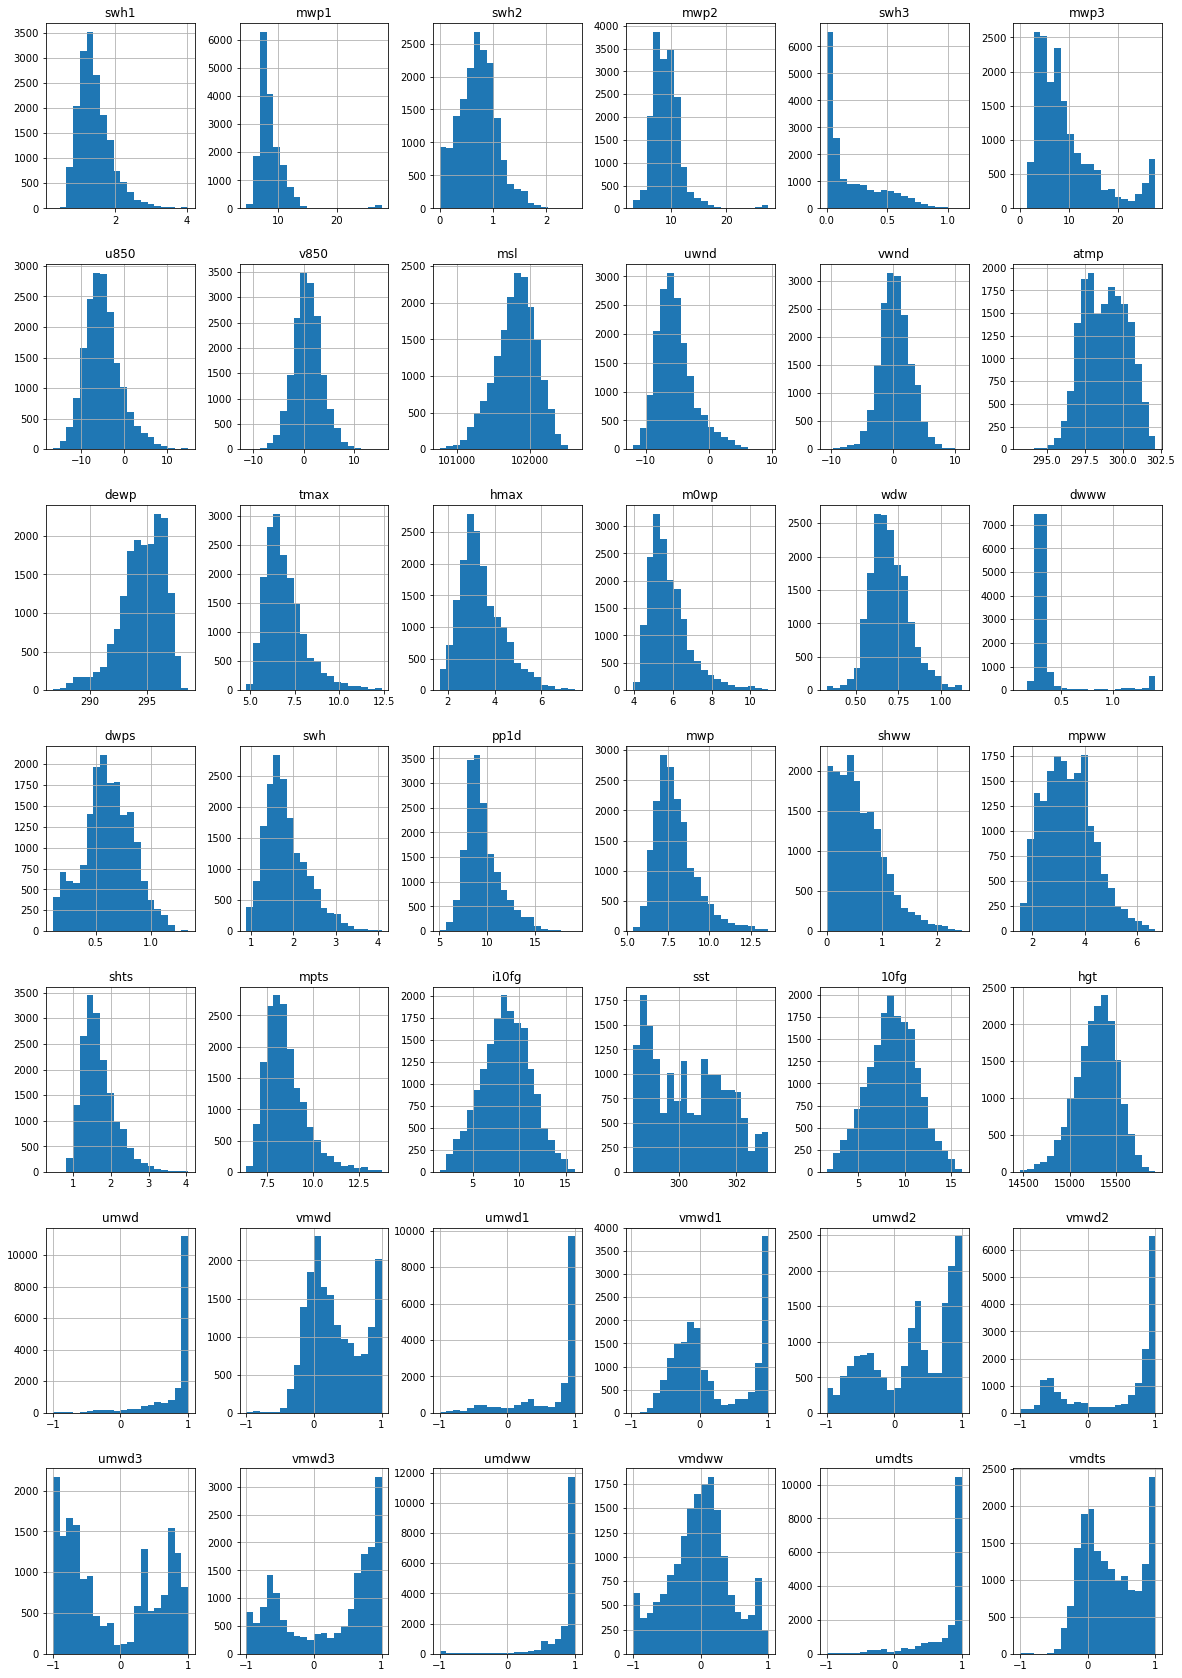

In [78]:
R.hist(figsize=(20,30),bins=20)

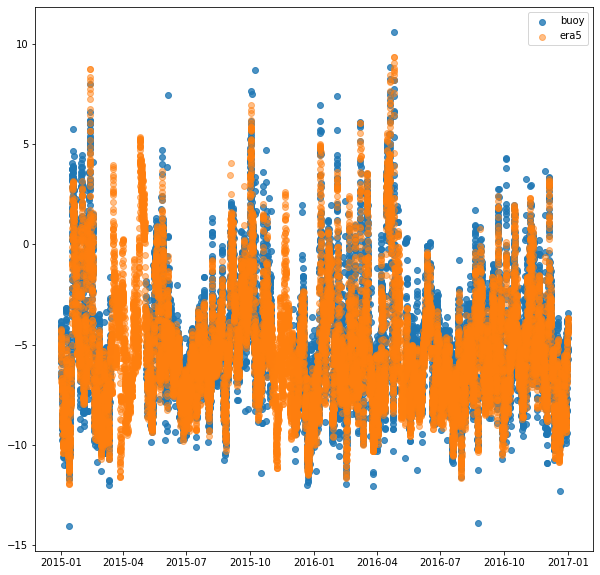

In [33]:
datesb = [pd.to_datetime(d) for d in B.index.get_level_values(1).values]
datesr = [pd.to_datetime(d) for d in R.index.get_level_values(2).values]

plt.figure(figsize=(10,10))
plt.scatter(datesb,B['uWDIR'].values,label='buoy',alpha=0.8)
plt.scatter(datesr,R['uwnd'].values,label='era5',alpha=0.5)
plt.legend()

In [453]:
k=2
B=directionComp(buoysdata.iloc[buoysdata.index.get_level_values('buoy')==buoyslist[k]],['WDIR'],['WSPD']).sort_values(by='time')
R=directionComp(reanalysis.iloc[reanalysis.index.get_level_values('buoy')==buoyslist[k]],
                ['mwd','mwd1','mwd2','mwd3','mdww','mdts'],[None,None,None,None,None,None]).sort_values(by='time')
aux=[0]*len(R)
year=np.unique([datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year for x in R.index.get_level_values('time')])
for i in range(len(R)):
    for j in year:
        if (datetime.datetime.strptime(R.index.get_level_values('time')[i],'%Y-%m-%d %H:%M:%S').year == j):   
            aux[i]=datetime.datetime.strptime(R.index.get_level_values('time')[i],'%Y-%m-%d %H:%M:%S')-datetime.datetime(j,1,1,0,0)
aux=np.array([x.total_seconds() for x in aux],dtype=np.float32)
R['cost']=np.cos(aux*np.pi*2/(np.max(aux)-np.min(aux)))
R['sint']=np.sin(aux*np.pi*2/(np.max(aux)-np.min(aux)))

Y=target(R,B)
#----Remove nans----------
index=np.unique(np.where(pd.isnull(Y))[0]) 
Y=Y.drop(index) 
X=R.drop(R.index[index])
y=Y.copy()
window=3
y.iloc[:,0]=y.iloc[:,0].rolling(window, min_periods=1, center=False, win_type=None, on=None, axis=0, closed=None).mean()
y.iloc[:,1]=y.iloc[:,1].rolling(window, min_periods=1, center=False, win_type=None, on=None, axis=0, closed=None).mean()

In [446]:
X_train, X_test, y_train, y_test, output_scaler = generate_dataset(StandardScaler(),MinMaxScaler(),X,y)

X_trainv, X_testv,y_trainv, y_testv = train_test_split(X_train,y_train,test_size=0.2,random_state=1)


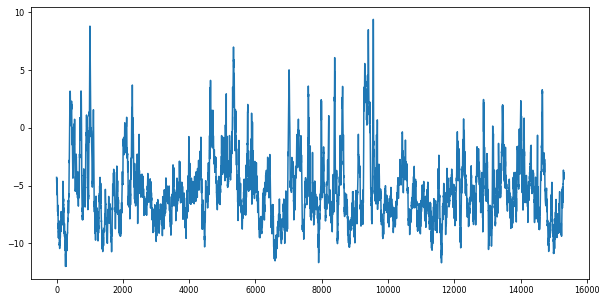

In [458]:
plt.figure(figsize=(10,5))
plt.plot(X['uwnd'].values,label='Train')

In [454]:
test_size=int(0.2*len(X))

In [456]:
X_train.index=np.arange(test_size,len(X))
X_test.index=np.arange(0,test_size)

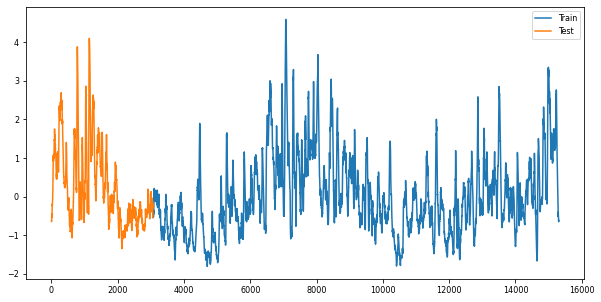

In [459]:
plt.rcParams.update({'font.size':8})
plt.figure(figsize=(10,5))
plt.plot(X_train.index.values,X_train['swh'].values,label='Train')
plt.plot(X_test.index.values,X_test['swh'].values,label='Test')
plt.legend()

In [ ]:
pca=PCA(.95) #95% of variance explained
pca.fit(X_trainv)
X_trainv=pca.transform(X_trainv)
X_testv=pca.transform(X_testv)
X_test=pca.transform(X_test)

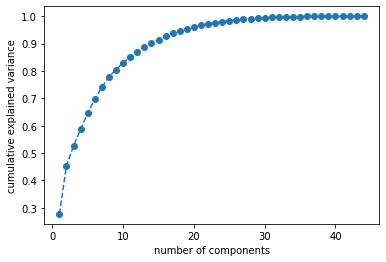

In [354]:
#-----PCA--------
pca1 = PCA().fit(StandardScaler().fit_transform(R))
plt.plot(range(1,len(R.columns) +1),np.cumsum(pca1.explained_variance_ratio_),marker='o',linestyle='--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

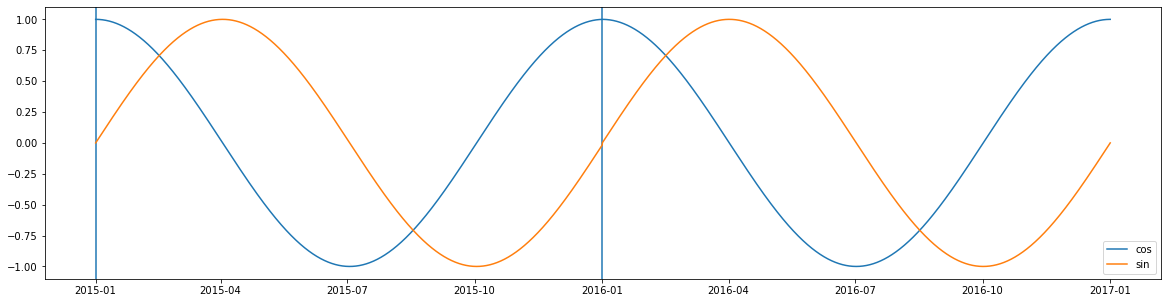

In [361]:
plt.figure(figsize=(20,5))
datesr = [pd.to_datetime(d) for d in R.index.get_level_values('time').values]
xcoords =[i for i, v in enumerate(R.index.get_level_values('time').values) if '01-01 00:00' in v]

for xc in xcoords:
    plt.axvline(x=datesr[xc])
plt.plot(datesr, R['cost'],label='cos')
plt.plot(datesr, R['sint'],label='sin')
plt.legend()

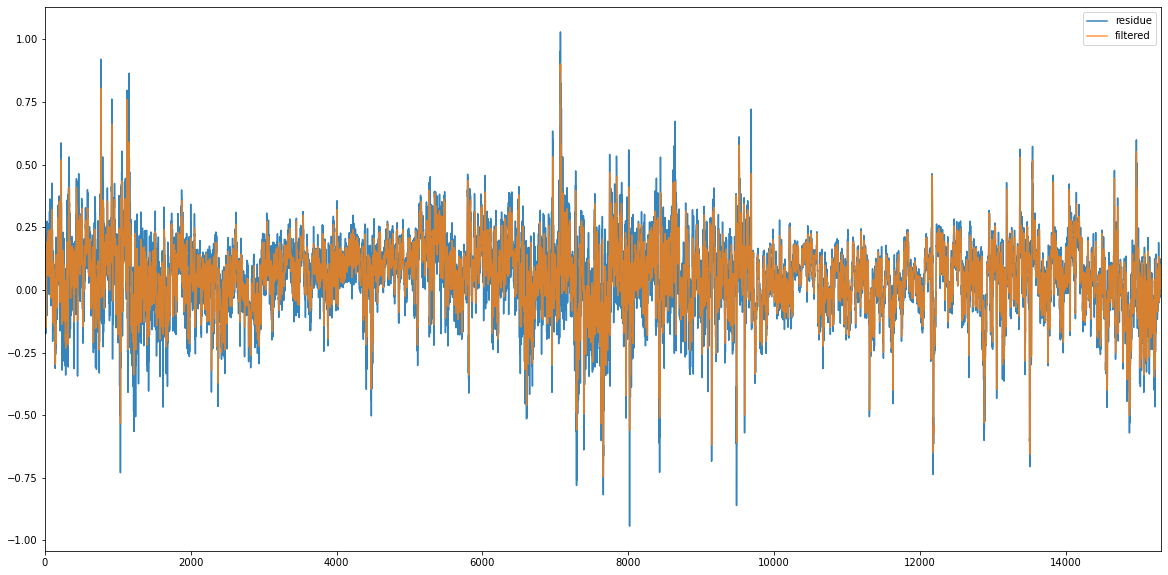

In [385]:
plt.figure(figsize=(20,10))

i=0
plt.plot(Y.iloc[:,i].values,label='residue',alpha=0.9)
plt.plot(y.iloc[:,i].values,label='filtered',alpha=0.8)
plt.legend()
plt.margins(x=0)

Epoch 1/1000
307/307 [==============================] - 1s 4ms/step - loss: 0.2186 - val_loss: 0.0604
Epoch 2/1000
307/307 [==============================] - 1s 2ms/step - loss: 0.0443 - val_loss: 0.0349
Epoch 3/1000
307/307 [==============================] - 1s 3ms/step - loss: 0.0284 - val_loss: 0.0245
Epoch 4/1000
307/307 [==============================] - 3s 9ms/step - loss: 0.0210 - val_loss: 0.0191
Epoch 5/1000
307/307 [==============================] - 3s 9ms/step - loss: 0.0166 - val_loss: 0.0155
Epoch 6/1000
307/307 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0133
Epoch 7/1000
307/307 [==============================] - 3s 8ms/step - loss: 0.0119 - val_loss: 0.0113
Epoch 8/1000
307/307 [==============================] - 1s 2ms/step - loss: 0.0104 - val_loss: 0.0104
Epoch 9/1000
307/307 [==============================] - 3s 9ms/step - loss: 0.0093 - val_loss: 0.0091
Epoch 10/1000
307/307 [==============================] - 1s 3ms/step - loss: 0.008

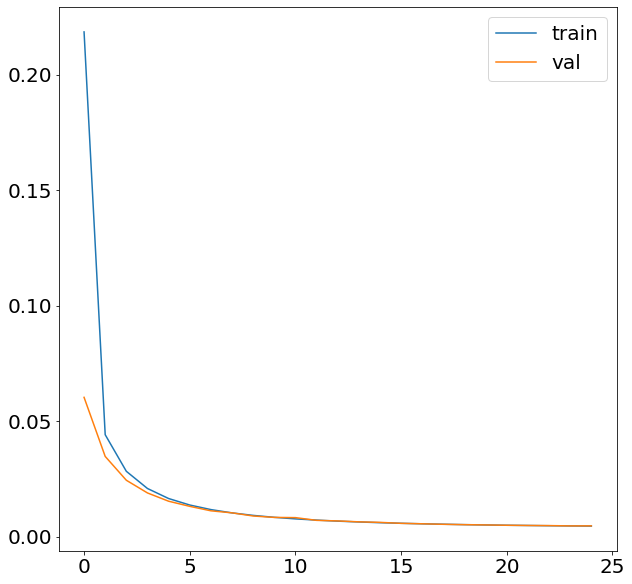

In [424]:

model=models.Sequential()
model.add(layers.Dense(20,input_dim=X_trainv.shape[1],activation='relu'))
model.add(layers.Dense(2))#output layer
model.compile(loss='mean_squared_error',optimizer='sgd')
monitor=EarlyStopping(monitor='val_loss',verbose=1)#with verbose=1 - print epoch where training stop
h=model.fit(X_trainv,y_trainv,validation_data=(X_testv,y_testv),callbacks=[monitor],epochs=1000,batch_size=32)
plt.figure(figsize=(10,10))
plt.plot(h.history['loss'], label='train')
plt.plot(h.history['val_loss'], label='val')
plt.legend()

In [ ]:
p=model.predict(X_test)

In [463]:
metrics=metricsB(output_scaler.inverse_transform(p)[:,0],output_scaler.inverse_transform(y_test)[:,0])

In [464]:
metrics

array([-0.04887441,  0.16113849, -0.9542386 ,  1.1019399 ,  0.15354773,
        1.0500308 ,  6.979778  ,  0.04013594], dtype=float32)

In [461]:
np.square(np.subtract(output_scaler.inverse_transform(y_test),output_scaler.inverse_transform(p))).mean()

0.5246169033284426

In [460]:
np.square(np.subtract(np.array(y_test),p)).mean()

0.006762088835394212

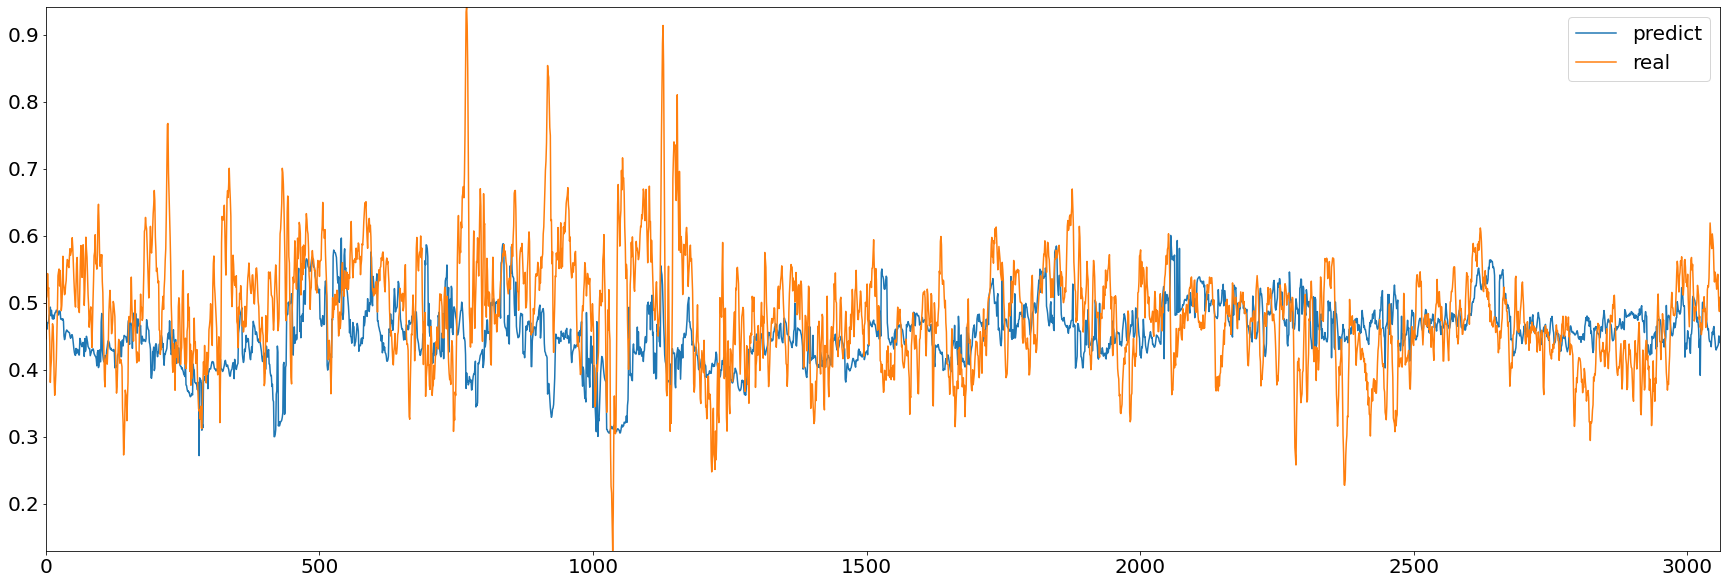

In [426]:
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(30,10))
plt.plot(p[:,0],label='predict')
plt.plot(np.array(y_test)[:,0],label='real')
plt.legend()
plt.margins(0)

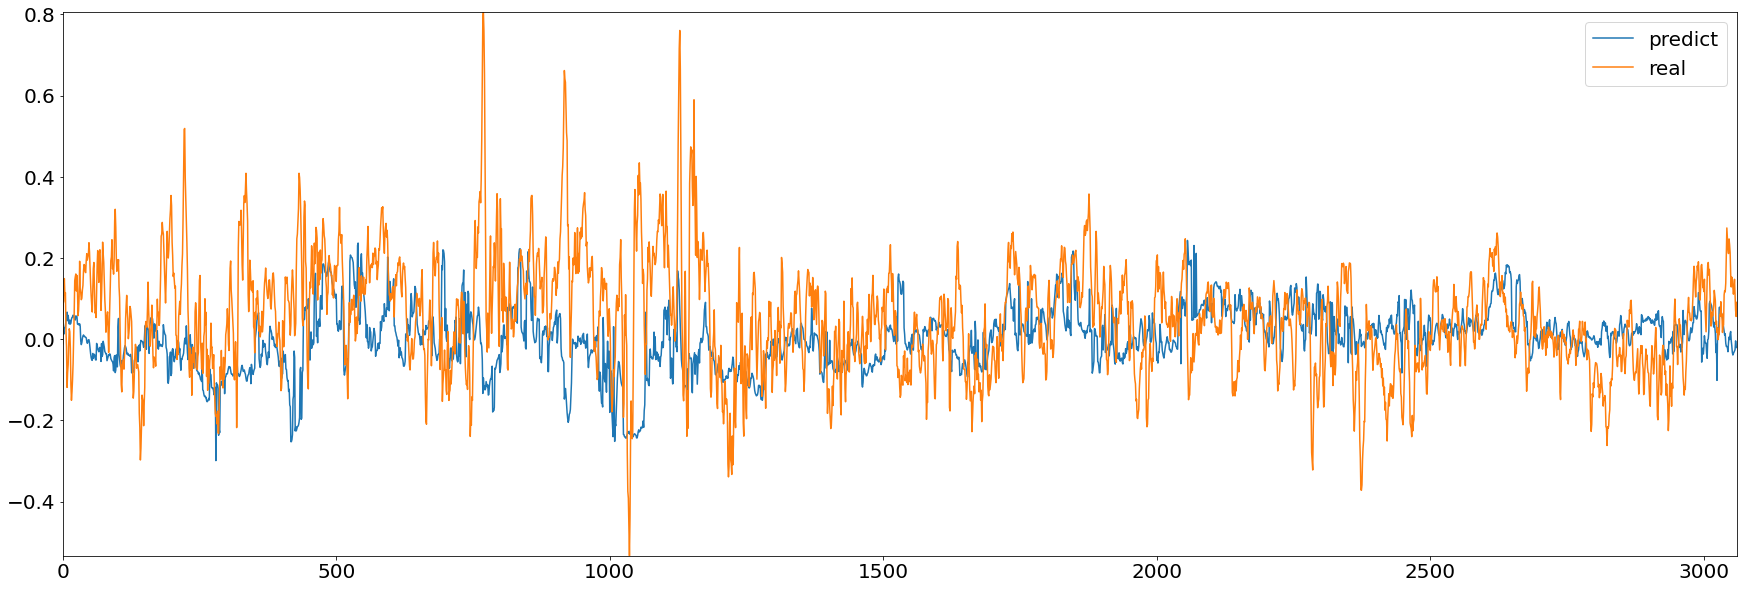

In [427]:
plt.figure(figsize=(30,10))
i=0
plt.plot(output_scaler.inverse_transform(p)[:,i],label='predict')
plt.plot(output_scaler.inverse_transform(y_test)[:,i],label='real')
plt.legend()
plt.margins(0)

In [462]:
#ver se com diferentes neurons os outros parametros mudam tambem nas melhores redes

r=talos.Reporting('nnet_opt/041521125314.csv')
r.data.sort_values(by='val_loss')

,round_epochs,loss,mse,val_loss,val_mse,activation,dropout,first_neuron,hidden_layers,kernel_initializer,lr,momentum,optimizer,shapes
152,38,0.003303,0.003303,0.003366,0.003366,relu,0.0,5,1,glorot_uniform,0.001,0.2,Adam,brick
225,36,0.003335,0.003335,0.003407,0.003407,relu,0.0,5,1,orthogonal,0.001,0.2,Adam,funnel
224,31,0.003351,0.003351,0.003417,0.003417,relu,0.0,5,1,orthogonal,0.001,0.2,Adam,brick
26,17,0.003396,0.003396,0.003488,0.003488,relu,0.0,5,0,glorot_uniform,0.100,0.9,SGD,brick
148,33,0.003400,0.003400,0.003501,0.003501,relu,0.0,5,1,glorot_uniform,0.001,0.5,Adam,brick
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,6,0.003919,0.003919,0.005999,0.005999,relu,0.0,5,0,glorot_uniform,0.100,0.5,Adam,funnel
63,6,0.003703,0.003703,0.007893,0.007893,relu,0.0,5,0,glorot_normal,0.100,0.9,SGD,funnel
67,4,0.003827,0.003827,0.008385,0.008385,relu,0.0,5,0,glorot_normal,0.100,0.5,SGD,funnel
27,2,NaN,NaN,NaN,NaN,relu,0.0,5,0,glorot_uniform,0.100,0.9,SGD,funnel


In [ ]:
neurons=np.arange(2,505,5)
seeds=np.arange(1,101)
h=[]
prediction=[]
for j in seeds:
    random.seed(j)
    tf.random.set_seed(j)
    X_trainv, X_testv,y_trainv, y_testv = train_test_split(X_train,y_train,test_size=0.2,random_state=j)
    pca=PCA(.95)
    pca.fit(X_trainv)
    X_trainv=pca.transform(X_trainv)
    X_testv=pca.transform(X_testv) 
    for i in neurons:
        model=models.Sequential()
        model.add(layers.Dense(i,input_dim=X_trainv.shape[1],activation='relu',kernel_initializer=))
        model.add(layers.Dropout())
        
        model.add(layers.Dense(y_trainv.shape[1]))#output layer
        
        opt=keras.optimizers.SGD(lr=params['lr'], momentum=params['momentum'], nesterov=True)
        
        model.compile(loss='mean_squared_error',optimizer=opt)
        monitor=EarlyStopping(monitor='val_loss',verbose=1,patience=2)
        
        history=model.fit(X_trainv,y_trainv,validation_data=(X_testv,y_testv),callbacks=[monitor],epochs=1000,batch_size=32)
        h.append(history)
        p=model.predict(X_test)
        prediction.append(p)

In [ ]:
mse=[i.history['val_loss'] for i in h]


In [ ]:

metrics=metricsB(output_scaler.p[i],output_scaler.inverse_transform(y_test))